In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [8]:
df = pd.read_csv("./wine-reviews.csv", usecols = ["country","description", "points","price","variety","winery"])

In [9]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [10]:
df = df.dropna(subset=["description", "points"])

In [11]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


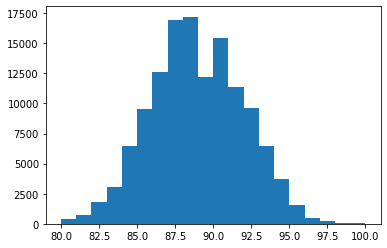

In [13]:
plt.hist(df.points, bins=20)
plt.show()

In [14]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [16]:
df.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [17]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [18]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [19]:
train_data = df_to_dataset(train)
test_data = df_to_dataset(test)
valid_data = df_to_dataset(val)

In [22]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"Affordable and appetizing, this has a lighter color and subtle smoke and toasted oak aromas. A firm texture accompanies just enough tannins and acidity, and bright red cherry and black tea flavors. It's lean in a good way, with excellent balance and a touch of austerity rather than overt richness.",
        b'Concentrated lilac and violet flowers paint a pretty picture to the beef char and creosote darkness on the nose of this bottling from a Los Olives vineyard. The palate blends boysenberry, blackberry, coffee and bittersweet dark chocolate, loaded atop a very firm structure.',
        b"This is Drouhan's second vintage of handling the vines, wines and marketing in partnership with the Hospices de Belleville charity. This open generous wine is packed with ripe red fruit and given shape by light tannins. There is a fresh crisp aftertaste that gives the wine a great lift.",
        ...,
        b'Made entirely with the Corvina 

In [26]:
#using a pre-built text model
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [28]:
model.evaluate(train_data)

102/102 [==============================] - 2s 10ms/step - loss: 0.7117 - accuracy: 0.3859


[0.7116906642913818, 0.3859352171421051]

In [29]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 113s 1s/step - loss: 0.6477 - accuracy: 0.6134 - val_loss: 0.5489 - val_accuracy: 0.7342
Epoch 2/5
102/102 [==============================] - 115s 1s/step - loss: 0.4947 - accuracy: 0.7584 - val_loss: 0.4008 - val_accuracy: 0.8166
Epoch 3/5
102/102 [==============================] - 107s 1s/step - loss: 0.4078 - accuracy: 0.8231 - val_loss: 0.3764 - val_accuracy: 0.8273
Epoch 4/5
102/102 [==============================] - 117s 1s/step - loss: 0.3690 - accuracy: 0.8437 - val_loss: 0.3707 - val_accuracy: 0.8317
Epoch 5/5
102/102 [==============================] - 122s 1s/step - loss: 0.3425 - accuracy: 0.8557 - val_loss: 0.3723 - val_accuracy: 0.8326


In [30]:
model.evaluate(test_data)

13/13 [==============================] - 1s 112ms/step - loss: 0.3763 - accuracy: 0.8314


[0.3763381242752075, 0.8313586711883545]

In [32]:
list(test_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'This field blend of Grenache, Zinfandel, Carignane and Cinsault was fermented in stainless steel and partially aged in neutral oak. Its strawberry and orange flavors combine effortlessly within its light, dry frame.',
        b"You've got to hand it to the folks at this estate: they make nice wines at low prices. This Sicilian Chardonnay is bright and creamy with aromas of orange blossom, almond, golden honey and mature apricot. The wine feels crisp and pristine in the mouth. Very nice.",
        b"Fragrant blue flower, plum, cake spice and a whiff of leather are some of the aromas you'll find on this stunning wine. Made with organically farmed Sangiovese, the juicy, delicious palate doles out ripe black cherry, fleshy blackberry, white pepper, licorice and grilled herb. It's open and well balanced, with firm, polished tannins. Drink through 2020.",
        ...,
        b'This wine, while rich, has all the minerality and crisp 

In [42]:
def test_wine_desc(wine_desc):
    new_description = [wine_desc]
    new_description_dataset = tf.data.Dataset.from_tensor_slices(new_description)
    new_description_dataset = new_description_dataset.batch(1)

    predictions = model.predict(new_description_dataset)
    threshold = 0.5
    predicted_labels = [1 if prediction > threshold else 0 for prediction in predictions]
    return predicted_labels[0] 

In [47]:
print(test_wine_desc("Wine wasn't good"))

1/1 [==============================] - 0s 104ms/step
0
